In [1]:
import fastjet_contribs

In [2]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import energyflow as ef
import torch
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Charter"
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = (
    r"\usepackage[bitstream-charter]{mathdesign} \usepackage{amsmath}"
)

FONTSIZE = 20
FONTSIZE_LEGEND = FONTSIZE
FONTSIZE_TICK = FONTSIZE
TICKLABELSIZE = 10

colors = ["black", "#0343DE", "#A52A2A", "darkorange"]

In [4]:
dataset = ak.from_parquet("/remote/gpu04/petitjean/high-dim-unfolding/data/ttbar/ttbar-t.parquet")
dataset2 = ak.from_parquet("/remote/gpu04/petitjean/high-dim-unfolding/data/ttbar/ttbar-tbar.parquet")
dataset = ak.concatenate([dataset, dataset2], axis=0)

In [5]:
nsub = dataset["nsub"]

In [6]:
gen_particles = dataset["gen_particles"]
rec_particles = dataset["rec_particles"]
gen_jets = dataset["gen_jets"]
rec_jets = dataset["rec_jets"]
gen_mults = ak.num(gen_particles, axis=1)
rec_mults = ak.num(rec_particles, axis=1)

In [7]:
def unpack_last(array):
    return array[..., 0], array[..., 1], array[..., 2], array[..., 3]

def jetmomenta_to_fourmomenta(jetmomenta):
    pt, phi, eta, m = unpack_last(jetmomenta)

    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = np.sqrt(m**2 + px**2 + py**2 + pz**2)

    fourmomenta = ak.concatenate((E[..., None], px[..., None], py[..., None], pz[..., None]), axis=-1)
    return fourmomenta

def fourmomenta_to_jetmomenta(fourmomenta):
    E, px, py, pz = unpack_last(fourmomenta)
    
    pt = np.sqrt(px**2 + py**2)
    phi = np.arctan2(py, px)
    eta = np.arctanh(pz / E)
    m = np.sqrt(E**2 - px**2 - py**2 - pz**2)
    return ak.concatenate((pt[..., None], phi[..., None], eta[..., None], m[..., None]), axis=-1)

In [8]:
mask = (ak.num(gen_particles, axis=1) >= 10) & (ak.num(rec_particles, axis=1) >= 10)
gen_particles = gen_particles[mask]
rec_particles = rec_particles[mask]


In [9]:
i = 8

In [11]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("ttbar_particles.pdf") as pdf:
    for i in range(10):
        fig, ax = plt.subplots(2,2,figsize=(10, 10))
        ax[0, 0].hist(gen_particles[:,i,0], bins=100, range=(0, 10), alpha=0.5, label="gen", histtype='step')
        ax[0, 0].hist(rec_particles[:,i,0], bins=100, range=(0, 10), alpha=0.5, label="rec", histtype='step')
        ax[0, 0].legend()
        ax[0, 0].set_xlabel("pt")
        ax[0, 0].set_ylabel("Density")
        ax[0, 1].hist(gen_particles[:,i,1], bins=100, range=(-4, 4), alpha=0.5, label="gen", histtype='step')
        ax[0, 1].hist(rec_particles[:,i,1], bins=100, range=(-4, 4), alpha=0.5, label="rec", histtype='step')
        ax[0, 1].legend()
        ax[0, 1].set_xlabel("phi")
        ax[0, 1].set_ylabel("Density")
        ax[1, 0].hist(gen_particles[:,i,2], bins=100, range=(-4, 4), alpha=0.5, label="gen", histtype='step')
        ax[1, 0].hist(rec_particles[:,i,2], bins=100, range=(-4, 4), alpha=0.5, label="rec", histtype='step')
        ax[1, 0].legend()
        ax[1, 0].set_xlabel("eta")
        ax[1, 0].set_ylabel("Density")
        ax[1, 1].hist(gen_particles[:,i,3], bins=100, range=(0, 1), alpha=0.5, label="gen", histtype='step')
        ax[1, 1].hist(rec_particles[:,i,3], bins=100, range=(0, 1), alpha=0.5, label="rec", histtype='step')
        ax[1, 1].legend()
        ax[1, 1].set_xlabel("m")
        ax[1, 1].set_ylabel("Density")
        plt.suptitle(f"Particle {i}")
        pdf.savefig(fig)
        plt.close(fig)

In [8]:
gen_particles = jetmomenta_to_fourmomenta(gen_particles)
rec_particles = jetmomenta_to_fourmomenta(rec_particles)

In [11]:
from multiprocessing import Pool, cpu_count
import numpy as np
from functools import partial

def compute_nsub_batch(particles_batch, N=1, beta=1.0, R0=1.2):
    # Process multiple particles at once to reduce overhead
    results = []
    for particles in particles_batch:
        results.append(fastjet_contribs.compute_nsubjettiness(
            particles[:, [1, 2, 3, 0]],
            N=N,
            beta=beta,
            R0=R0
        ))
    return results

def process_all_events(particles, batch_size=1000):
    # Create batches
    n_events = len(particles)
    batches = [particles[i:i + batch_size] for i in range(0, n_events, batch_size)]
    
    # Use fewer processes with larger batches
    n_cores = cpu_count() - 1  # Leave one core free
    
    with Pool(processes=n_cores) as pool:
        results = []
        for batch_result in pool.imap(compute_nsub_batch, batches):
            results.extend(batch_result)
            
    return np.array(results)

# Usage
batch_size = 1000  # Adjust based on memory and performance
results = process_all_events(gen_particles[:50000], batch_size=batch_size)

#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

In [13]:
results.shape

(50000,)

In [ ]:
gen_jets = jetmomenta_to_fourmomenta(gen_jets)
rec_jets = jetmomenta_to_fourmomenta(rec_jets)

In [ ]:
summed_gen_jets = ak.sum(gen_particles,axis=1)
summed_rec_jets = ak.sum(rec_particles,axis=1)

Text(0, 0.5, 'Density')

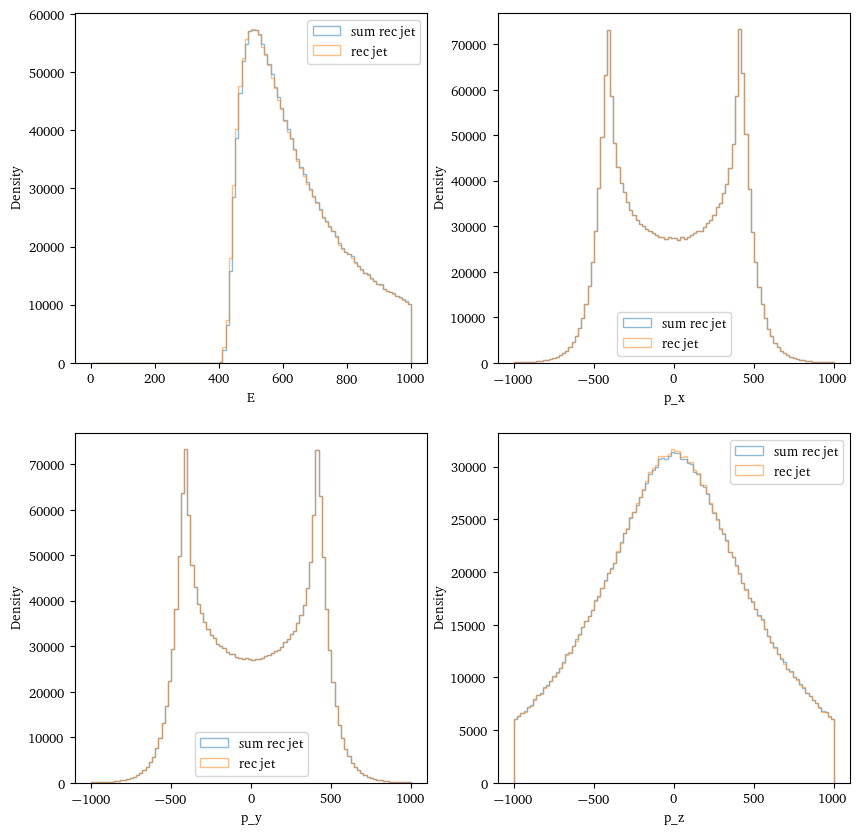

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))
#ax[0, 0].hist(gen_jets[:,3], bins=100, range=(150, 200), alpha=0.5, label="gen jet", histtype='step')
ax[0, 0].hist(summed_rec_jets[:,0], bins=100, range=(0, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 0].hist(rec_jets[:,0], bins=100, range=(0, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[0, 0].legend()
ax[0, 0].set_xlabel("E")
ax[0, 0].set_ylabel("Density")
#ax[0, 1].hist(gen_jets[:,0], bins=100, range=(300, 1000), alpha=0.5, label="gen jet", histtype='step')
ax[0, 1].hist(summed_rec_jets[:,1], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[0, 1].hist(rec_jets[:,1], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[0, 1].legend()
ax[0, 1].set_xlabel("p_x")
ax[0, 1].set_ylabel("Density")
#ax[1, 0].hist(gen_jets[:,1], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 0].hist(summed_rec_jets[:,2], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 0].hist(rec_jets[:,2], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[1, 0].legend()
ax[1, 0].set_xlabel("p_y")
ax[1, 0].set_ylabel("Density")
#ax[1, 1].hist(gen_jets[:,2], bins=100, range=(-5, 5), alpha=0.5, label="gen jet", histtype='step')
ax[1, 1].hist(summed_rec_jets[:,3], bins=100, range=(-1000, 1000), alpha=0.5, label="sum rec jet", histtype='step')
ax[1, 1].hist(rec_jets[:,3], bins=100, range=(-1000, 1000), alpha=0.5, label="rec jet", histtype='step')
ax[1, 1].legend()
ax[1, 1].set_xlabel("p_z")
ax[1, 1].set_ylabel("Density")

In [ ]:
gen_jets = fourmomenta_to_jetmomenta(gen_jets)
rec_jets = fourmomenta_to_jetmomenta(rec_jets)

/remote/gpu04/petitjean/high-dim-unfolding/venv/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


In [ ]:
summed_gen_jets = fourmomenta_to_jetmomenta(summed_gen_jets)
summed_rec_jets = fourmomenta_to_jetmomenta(summed_rec_jets)

In [ ]:
print(gen_mults.type.show(), rec_mults.type.show())

2044187 * int64
2044187 * int64
None None


In [ ]:
with PdfPages("/remote/gpu04/petitjean/high-dim-unfolding/notebooks/plots/ttbar.pdf") as pdf:
    bins = np.linspace(380,1000, 100)
    plt.hist(summed_gen_jets[:,0], bins=bins, label='Particle-level jet', histtype='step', density=True)
    plt.hist(summed_rec_jets[:,0], bins=bins, label='Detector-level jet', histtype='step', density=True)
    plt.legend(fontsize=FONTSIZE_LEGEND)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE)
    plt.xlim(380, 1000)
    plt.xlabel(r'$p_T$ [GeV]', fontsize=FONTSIZE)
    plt.ylabel('Density', fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(pdf, bbox_inches="tight", format="pdf")
    plt.close()
    bins = np.linspace(-3.5,3.5, 100)
    plt.hist(summed_gen_jets[:,1], bins=bins, label='Particle-level jet', histtype='step', density=True)
    plt.hist(summed_rec_jets[:,1], bins=bins, label='Detector-level jet', histtype='step', density=True)
    plt.legend(fontsize=FONTSIZE_LEGEND)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE)
    plt.xlim(-3.5, 3.5)
    plt.xlabel(r'$\phi$', fontsize=FONTSIZE)
    plt.ylabel('Density', fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(pdf, bbox_inches="tight", format="pdf")
    plt.close()
    bins = np.linspace(-3,3, 100)
    plt.hist(summed_gen_jets[:,2], bins=bins, label='Particle-level jet', histtype='step', density=True)
    plt.hist(summed_rec_jets[:,2], bins=bins, label='Detector-level jet', histtype='step', density=True)
    plt.legend(fontsize=FONTSIZE_LEGEND)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE)
    plt.xlim(-3, 3)
    plt.xlabel(r'$\eta$', fontsize=FONTSIZE)
    plt.ylabel('Density', fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(pdf, bbox_inches="tight", format="pdf")
    plt.close()
    bins = np.linspace(110,210, 100)
    plt.hist(summed_gen_jets[:,3], bins=bins, label='Particle-level jet', histtype='step', density=True)
    plt.hist(summed_rec_jets[:,3], bins=bins, label='Detector-level jet', histtype='step', density=True)
    plt.legend(fontsize=FONTSIZE_LEGEND)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE)
    plt.xlim(110, 210)
    plt.xlabel(r'$M_t$ [GeV]', fontsize=FONTSIZE)
    plt.ylabel('Density', fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(pdf, bbox_inches="tight", format="pdf")
    plt.close()
    bins = np.arange(10, 150)
    plt.hist(gen_mults, bins=bins, label='Particle-level jet', histtype='step', density=True)
    plt.hist(rec_mults, bins=bins, label='Detector-level jet', histtype='step', density=True)
    plt.legend(fontsize=FONTSIZE_LEGEND)
    plt.xticks(fontsize=FONTSIZE-2)
    plt.yticks(fontsize=FONTSIZE)
    plt.xlim(10, 150)
    plt.xlabel('Multiplicity', fontsize=FONTSIZE)
    plt.ylabel('Density', fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(pdf, bbox_inches="tight", format="pdf")
    plt.close()
